In [4]:
import json
from pathlib import Path

import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
from google.colab import drive
drive.mount("/content/drive")
BASE_DIR = "/content/drive/MyDrive/data/imaestro-patch64-block10-42"

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

In [69]:
configs = {
    # data
    "batch_size": 8,

    # model
    "base_channels": 64,
    "dropout": 0.2,

    # training
    "epochs": 60,
    "patience": 10,
    "base_lr": 1e-4,
    "max_lr": 3e-4,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",  # or None

    # multi-task loss weights
    "seg_weight": 1.0,
    "height_weight": 1.0,
    "biomass_weight": 1.0,
}


IGNORE_INDEX = -1  # for segmentation ignore_index
S1_MIN_THRESHOLD = 999  # dB clipping for Sentinel-1 backscatter
S1_MAX_THRESHOLD = -999

In [6]:
def load_all_patches(base_dir: str):
    base_path = Path(base_dir)
    patches_train = np.load(base_path / "patches_train.npy")  # (N, 5, 64, 64)
    patches_val = np.load(base_path / "patches_val.npy")
    patches_test = np.load(base_path / "patches_test.npy")

    # Channel order in patches_: 0: VH, 1: VV, 2: biomass, 3: genus, 4: height
    genus_train = patches_train[:, 3, ...]
    genus_val = patches_val[:, 3, ...]
    genus_test = patches_test[:, 3, ...]

    all_genus = np.concatenate(
        [genus_train.reshape(-1), genus_val.reshape(-1), genus_test.reshape(-1)]
    )
    mask = np.isfinite(all_genus) & (all_genus > 0)
    codes = np.unique(all_genus[mask].astype(int))
    codes_sorted = sorted(int(c) for c in codes)
    code_to_index = {code: idx for idx, code in enumerate(codes_sorted)}
    index_to_code = {idx: code for code, idx in code_to_index.items()}

    print("Genus codes used in dataset (code -> index):")
    print(code_to_index)

    return (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    )


class IMAESTROSegDataset(Dataset):
    """Dataset for multi-task learning on 64x64 patches.

    Inputs:
        - x: Sentinel-1 VH/VV (2 channels), clipped to [S1_MIN_THRESHOLD, S1_MAX_THRESHOLD].
    Targets:
        - y_seg: genus segmentation, shape (H, W), with labels in [0, num_classes-1]
                 and IGNORE_INDEX for invalid pixels.
        - y_height: height95 map, shape (1, H, W), NaN for invalid pixels.
        - y_biomass: biomass_t_ha map, shape (1, H, W), NaN for invalid pixels.
    """

    def __init__(
        self,
        patches: np.ndarray,
        code_to_index: dict[int, int],
        ignore_index: int = IGNORE_INDEX,
    ) -> None:
        super().__init__()

        if patches.ndim != 4:
            raise ValueError(f"Expected patches of shape (N, C, H, W), got {patches.shape}")

        vh = patches[:, 0, ...].astype(np.float32)
        vv = patches[:, 1, ...].astype(np.float32)
        s1 = np.stack([vh, vv], axis=1)

        biomass = patches[:, 2, ...].astype(np.float32)
        genus_raw = patches[:, 3, ...].astype(np.float32)
        height = patches[:, 4, ...].astype(np.float32)

        # Handle NaN / NoData for regression targets
        def _clean_reg_target(arr: np.ndarray) -> np.ndarray:
            out = arr.copy()
            # Treat very negative values (e.g., -9999) as invalid
            mask_invalid = ~np.isfinite(out) | (out < -1e3)
            out[mask_invalid] = np.nan
            return out

        biomass = _clean_reg_target(biomass)
        height = _clean_reg_target(height)

        # Genus segmentation: map codes -> contiguous indices, others -> IGNORE_INDEX
        genus = np.full_like(genus_raw, ignore_index, dtype=np.int64)
        valid_mask = np.isfinite(genus_raw) & (genus_raw > 0)
        genus_int = genus_raw[valid_mask].astype(int)

        # Vectorized mapping from code to index
        if len(code_to_index) > 0:
            mapped = np.vectorize(lambda c: code_to_index.get(int(c), ignore_index))(
                genus_int
            )
            genus[valid_mask] = mapped

        self.inputs = torch.from_numpy(s1)  # (N, 2, H, W)
        self.seg_targets = torch.from_numpy(genus.astype(np.int64))  # (N, H, W)
        self.height_targets = torch.from_numpy(height).unsqueeze(1)  # (N, 1, H, W)
        self.biomass_targets = torch.from_numpy(biomass).unsqueeze(1)  # ditto

    def __len__(self) -> int:  # type: ignore[override]
        return self.inputs.shape[0]

    def __getitem__(self, idx: int):  # type: ignore[override]
        x = self.inputs[idx]
        y_seg = self.seg_targets[idx]
        y_h = self.height_targets[idx]
        y_b = self.biomass_targets[idx]
        return x, y_seg, y_h, y_b


def make_datasets(base_dir: str):
    (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    ) = load_all_patches(base_dir)

    train_ds = IMAESTROSegDataset(patches_train, code_to_index, IGNORE_INDEX)
    val_ds = IMAESTROSegDataset(patches_val, code_to_index, IGNORE_INDEX)
    test_ds = IMAESTROSegDataset(patches_test, code_to_index, IGNORE_INDEX)

    print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
    num_classes = len(code_to_index)
    return train_ds, val_ds, test_ds, num_classes, code_to_index, index_to_code

In [70]:
def visualize_dataset_triplet_sample(
    train_ds: IMAESTROSegDataset,
    val_ds: IMAESTROSegDataset,
    test_ds: IMAESTROSegDataset,
    idx_train: int = 0,
    idx_val: int = 0,
    idx_test: int = 0,
    num_classes: int = 0,
) -> None:
    """Visualize one sample from train/val/test datasets.

    Each row corresponds to a split (Train / Val / Test) and shows:
        VV, VH, genus segmentation (index), height, biomass.
    """

    samples = [
        ("Train", train_ds, int(idx_train)),
        ("Val", val_ds, int(idx_val)),
        ("Test", test_ds, int(idx_test)),
    ]

    n = len(samples)

    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(3 * 5, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row, (split_name, ds, idx) in enumerate(samples):
        ax_row = axes[row]
        x, y_seg, y_h, y_b = ds[idx]

        x_np = x.cpu().numpy()
        y_seg_np = y_seg.cpu().numpy()
        y_h_np = y_h.cpu().numpy()[0]
        y_b_np = y_b.cpu().numpy()[0]

        vv = x_np[1, :, :]
        vh = x_np[0, :, :]
        seg = y_seg_np.copy()

        mask_invalid = ~np.isfinite(seg) | (seg == IGNORE_INDEX)
        seg = np.ma.array(seg, mask=mask_invalid)

        images = [vv, vh, seg, y_h_np, y_b_np]
        titles = ["VV", "VH", "Genus index", "Height", "Biomass"]

        for col in range(5):
            ax = ax_row[col]
            band = images[col]

            if col in (0, 1):
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            elif col == 2:
                cmap = "tab20"
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )
            else:
                cmap = "viridis"
                im = ax.imshow(band, cmap=cmap)

            if row == 0:
                ax.set_title(titles[col])
            if col == 0:
                ax.set_ylabel(split_name)
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### data

In [71]:
train_ds, val_ds, test_ds, num_classes, code_to_index, index_to_code = make_datasets(BASE_DIR)

train_loader = DataLoader(
    train_ds,
    batch_size=configs["batch_size"],
    shuffle=True,
    num_workers=2,
)
val_loader = DataLoader(
    val_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)

Genus codes used in dataset (code -> index):
{1: 0, 2: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 13: 9, 16: 10, 17: 11, 19: 12, 20: 13, 21: 14, 22: 15, 25: 16, 26: 17, 27: 18, 28: 19, 30: 20, 31: 21}
Train: 726 Val: 154 Test: 153


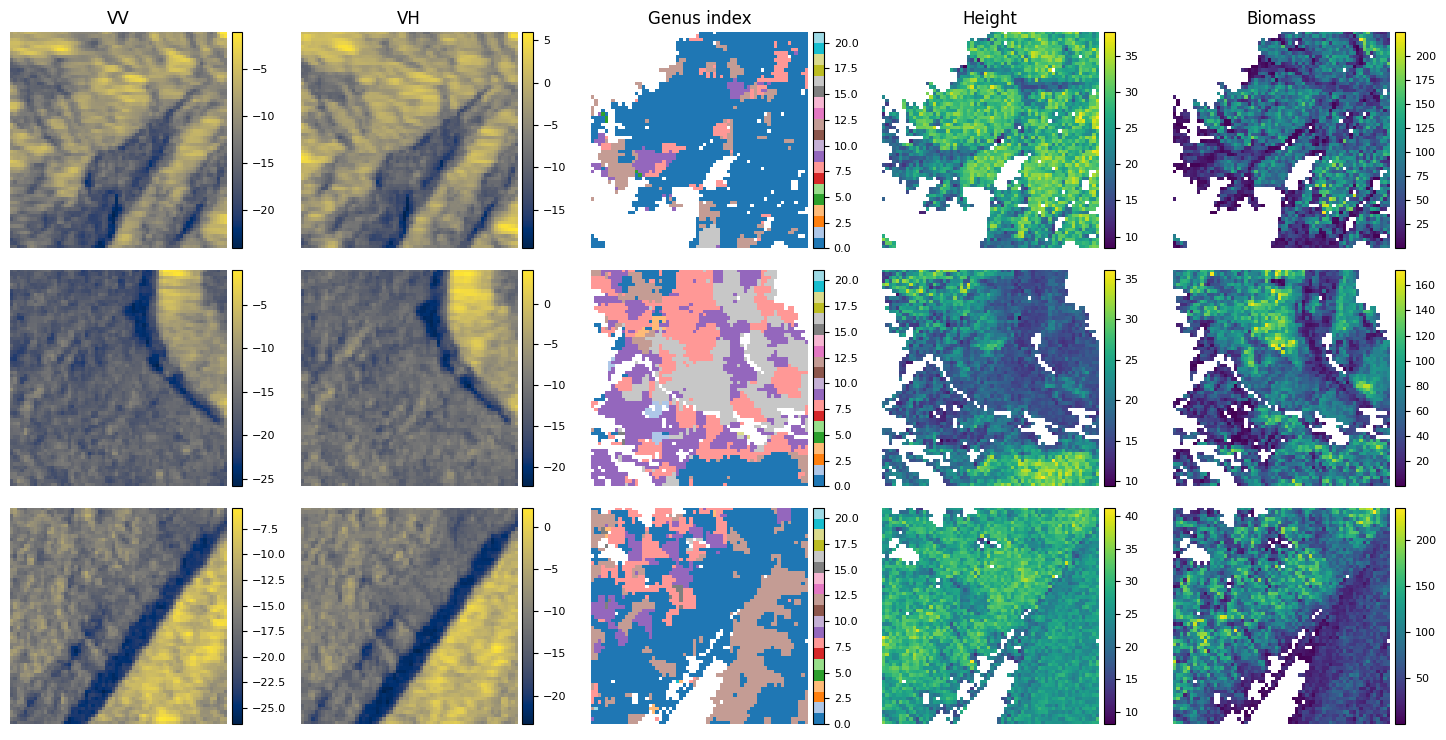

In [72]:
visualize_dataset_triplet_sample(
    train_ds,
    val_ds,
    test_ds,
    idx_train=5,
    idx_val=5,
    idx_test=5,
    num_classes=num_classes,
)

## Model

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        # after upsampling, features are concatenated with skip connection
        # so DoubleConv expects in_channels and produces out_channels
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x = self.up(x)
        # shapes should match exactly (64 -> 32 -> 16 -> 8)
        if x.shape[-2:] != skip.shape[-2:]:
            # simple padding/cropping guard (should rarely trigger)
            min_h = min(x.shape[-2], skip.shape[-2])
            min_w = min(x.shape[-1], skip.shape[-1])
            x = x[..., :min_h, :min_w]
            skip = skip[..., :min_h, :min_w]
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

### Segmentation

In [19]:
class SegmentationUNet(nn.Module):
    """U-Net for genus segmentation only (no regression heads)."""

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        self.up3 = Up(base_channels * 8, base_channels * 4)
        self.up2 = Up(base_channels * 4, base_channels * 2)
        self.up1 = Up(base_channels * 2, base_channels)
        self.drop = nn.Dropout2d(p=dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x1 = self.enc1(x)
        x2 = self.down1(x1)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)
        x5 = self.bottleneck(x4)

        s = self.up3(x5, x3)
        s = self.up2(s, x2)
        s = self.up1(s, x1)
        s = self.drop(s)
        seg_logits = self.out_seg(s)
        return seg_logits

### Regression

In [20]:
class RegressionUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        self.up3 = Up(base_channels * 8, base_channels * 4)
        self.up2 = Up(base_channels * 4, base_channels * 2)
        self.up1 = Up(base_channels * 2, base_channels)
        self.drop = nn.Dropout2d(p=dropout)
        self.out_reg = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x1 = self.enc1(x)
        x2 = self.down1(x1)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)
        x5 = self.bottleneck(x4)

        r = self.up3(x5, x3)
        r = self.up2(r, x2)
        r = self.up1(r, x1)
        r = self.drop(r)
        preds = self.out_reg(r)  # (N, out_channels, H, W)
        return preds

In [21]:
class MultiTaskUNet(nn.Module):
    """U-Net with shared encoder and three heads:

    - seg_head: genus segmentation (N, num_classes, 64, 64)
    - height_head: height regression (N, 1, 64, 64)
    - biomass_head: biomass regression (N, 1, 64, 64)
    """

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)  # 64 -> 32
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)  # 32 -> 16
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)  # 16 -> 8
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        # Segmentation decoder
        self.up3_seg = Up(base_channels * 8, base_channels * 4)
        self.up2_seg = Up(base_channels * 4, base_channels * 2)
        self.up1_seg = Up(base_channels * 2, base_channels)
        self.drop_seg = nn.Dropout2d(p=dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

        # Height regression decoder
        self.up3_h = Up(base_channels * 8, base_channels * 4)
        self.up2_h = Up(base_channels * 4, base_channels * 2)
        self.up1_h = Up(base_channels * 2, base_channels)
        self.drop_h = nn.Dropout2d(p=dropout)
        self.out_h = nn.Conv2d(base_channels, 1, kernel_size=1)

        # Biomass regression decoder
        self.up3_b = Up(base_channels * 8, base_channels * 4)
        self.up2_b = Up(base_channels * 4, base_channels * 2)
        self.up1_b = Up(base_channels * 2, base_channels)
        self.drop_b = nn.Dropout2d(p=dropout)
        self.out_b = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor):  # type: ignore[override]
        # Shared encoder
        x1 = self.enc1(x)  # (N, C, 64, 64)
        x2 = self.down1(x1)  # (N, 2C, 32, 32)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)  # (N, 4C, 16, 16)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)  # (N, 8C, 8, 8)
        x5 = self.bottleneck(x4)

        # Segmentation branch
        s = self.up3_seg(x5, x3)
        s = self.up2_seg(s, x2)
        s = self.up1_seg(s, x1)
        s = self.drop_seg(s)
        seg_logits = self.out_seg(s)

        # Height branch
        h = self.up3_h(x5, x3)
        h = self.up2_h(h, x2)
        h = self.up1_h(h, x1)
        h = self.drop_h(h)
        height = self.out_h(h)

        # Biomass branch
        b = self.up3_b(x5, x3)
        b = self.up2_b(b, x2)
        b = self.up1_b(b, x1)
        b = self.drop_b(b)
        biomass = self.out_b(b)

        return seg_logits, height, biomass

## Training Functions

In [22]:
def masked_rmse_loss(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """RMSE ignoring NaN values in targets.

    preds, targets: (N, 1, H, W)
    """

    mask = torch.isfinite(targets)
    if not mask.any():
        return (preds * 0.0).sum()
    diff = preds[mask] - targets[mask]
    return torch.sqrt(torch.mean(diff ** 2))


def compute_segmentation_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    num_classes: int,
    ignore_index: int = IGNORE_INDEX,
):
    """Compute pixel accuracy and mean IoU for segmentation.

    y_true, y_pred: (N, H, W) integer arrays.
    """

    mask = y_true != ignore_index
    if not mask.any():
        return {
            "pixel_acc": float("nan"),
            "mean_iou": float("nan"),
            "per_class_iou": [float("nan")] * num_classes,
        }

    y_true_flat = y_true[mask].ravel()
    y_pred_flat = y_pred[mask].ravel()

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))
    correct = np.diag(cm).astype(float)
    total = cm.sum().astype(float)
    pixel_acc = float(correct.sum() / total) if total > 0 else float("nan")

    union = cm.sum(axis=1) + cm.sum(axis=0) - correct
    iou = np.where(union > 0, correct / (union + 1e-6), np.nan)
    mean_iou = float(np.nanmean(iou))

    return {
        "pixel_acc": pixel_acc,
        "mean_iou": mean_iou,
        "per_class_iou": iou.tolist(),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
):
    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_samples = 0

    desc = f"Train {epoch}" if epoch is not None else "Train"

    for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        seg_logits, h_pred, b_pred = model(x)

        loss_seg = seg_criterion(seg_logits, y_seg)
        loss_h = reg_criterion(h_pred, y_h)
        loss_b = reg_criterion(b_pred, y_b)

        loss = seg_weight * loss_seg + height_weight * loss_h + biomass_weight * loss_b
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_seg_loss += float(loss_seg.item()) * bs
        total_h_loss += float(loss_h.item()) * bs
        total_b_loss += float(loss_b.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)

    return {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
    }


def evaluate(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    device: str,
    desc: str = "Eval",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
):
    model.eval()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []
    all_true_h = []
    all_pred_h = []
    all_true_b = []
    all_pred_b = []

    with torch.no_grad():
        for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            seg_logits, h_pred, b_pred = model(x)

            loss_seg = seg_criterion(seg_logits, y_seg)
            loss_h = reg_criterion(h_pred, y_h)
            loss_b = reg_criterion(b_pred, y_b)
            loss = seg_weight * loss_seg + height_weight * loss_h + biomass_weight * loss_b

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_seg_loss += float(loss_seg.item()) * bs
            total_h_loss += float(loss_h.item()) * bs
            total_b_loss += float(loss_b.item()) * bs
            total_samples += bs

            # Segmentation predictions
            seg_pred = torch.argmax(seg_logits, dim=1)  # (N, H, W)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

            # Regression targets/predictions
            all_true_h.append(y_h.cpu().numpy())
            all_pred_h.append(h_pred.cpu().numpy())
            all_true_b.append(y_b.cpu().numpy())
            all_pred_b.append(b_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0)  # (N, 1, H, W)
        arr = arr.reshape(-1)
        return arr

    # Height metrics
    h_true = _flatten_valid(all_true_h)
    h_pred = _flatten_valid(all_pred_h)
    mask_h = np.isfinite(h_true)
    if mask_h.any():
        h_true_m = h_true[mask_h]
        h_pred_m = h_pred[mask_h]
        h_rmse = float(
            math.sqrt(float(np.mean((h_pred_m - h_true_m) ** 2)))
        )
        h_r2 = float(r2_score(h_true_m, h_pred_m))
    else:
        h_rmse = float("nan")
        h_r2 = float("nan")

    # Biomass metrics
    b_true = _flatten_valid(all_true_b)
    b_pred = _flatten_valid(all_pred_b)
    mask_b = np.isfinite(b_true)
    if mask_b.any():
        b_true_m = b_true[mask_b]
        b_pred_m = b_pred[mask_b]
        b_rmse = float(
            math.sqrt(float(np.mean((b_pred_m - b_true_m) ** 2)))
        )
        b_r2 = float(r2_score(b_true_m, b_pred_m))
    else:
        b_rmse = float("nan")
        b_r2 = float("nan")

    metrics = {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
        "pixel_acc": seg_metrics["pixel_acc"],
        "mean_iou": seg_metrics["mean_iou"],
        "height_rmse": h_rmse,
        "height_r2": h_r2,
        "biomass_rmse": b_rmse,
        "biomass_r2": b_r2,
    }

    return metrics, seg_metrics


def train_one_epoch_segmentation(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
):
    """Train one epoch for segmentation-only models."""
    model.train()
    total_loss = 0.0
    total_samples = 0

    desc = f"Train Seg {epoch}" if epoch is not None else "Train Seg"

    for x, y_seg, _, _ in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = seg_criterion(logits, y_seg)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_samples += bs

    return total_loss / max(total_samples, 1)


def evaluate_segmentation(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    device: str,
    desc: str = "Eval Seg",
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
):
    """Evaluate segmentation-only models with CE loss and seg metrics."""
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)

            logits = model(x)
            loss = seg_criterion(logits, y_seg)

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_samples += bs

            seg_pred = torch.argmax(logits, dim=1)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    metrics = {
        "loss": avg_loss,
        "pixel_acc": seg_metrics["pixel_acc"],
        "mean_iou": seg_metrics["mean_iou"],
    }
    return metrics, seg_metrics

In [23]:
def train_one_epoch_regression(
    model: nn.Module,
    loader: DataLoader,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    target: str = "height",
):
    """Train one epoch for single-task regression-only models.

    target: "height" or "biomass".
    Model output is assumed to be (N, 1, H, W).
    """
    model.train()
    total_loss = 0.0
    total_samples = 0

    desc = f"Train Reg {target} {epoch}" if epoch is not None else f"Train Reg {target}"

    for x, _, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        preds = model(x)  # (N, 1, H, W)

        if target == "height":
            y_t = y_h
        else:
            y_t = y_b

        loss = reg_criterion(preds, y_t)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)

    metrics = {"loss": avg_loss}
    key = f"{target}_loss"
    metrics[key] = avg_loss
    return metrics


def evaluate_regression(
    model: nn.Module,
    loader: DataLoader,
    reg_criterion,
    device: str,
    desc: str = "Eval Reg",
    target: str = "height",
):
    """Evaluate single-task regression-only models.

    target: "height" or "biomass".
    Model output is assumed to be (N, 1, H, W).
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            preds = model(x)  # (N, 1, H, W)

            if target == "height":
                targets = y_h
            else:
                targets = y_b

            loss = reg_criterion(preds, targets)

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_samples += bs

            all_true.append(targets.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0).reshape(-1)
        return arr

    y_true = _flatten_valid(all_true)
    y_pred = _flatten_valid(all_pred)
    mask = np.isfinite(y_true)
    if mask.any():
        y_true_m = y_true[mask]
        y_pred_m = y_pred[mask]
        rmse = float(math.sqrt(float(np.mean((y_pred_m - y_true_m) ** 2))))
        r2 = float(r2_score(y_true_m, y_pred_m))
    else:
        rmse = float("nan")
        r2 = float("nan")

    metrics = {
        "loss": avg_loss,
        f"{target}_loss": avg_loss,
        f"{target}_rmse": rmse,
        f"{target}_r2": r2,
    }

    return metrics

## Visualization

### segmentation samples

In [24]:
def visualize_segmentation_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    num_classes: int = num_classes,
) -> None:
    """Visualize VV/VH and segmentation (true & pred) for a few samples.

    Each row shows (VV, VH, true segmentation, predicted segmentation).
    VV/VH use the "cividis" colormap, segmentation uses a discrete colormap.
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_seg = dataset.seg_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            seg_logits = out[0]
        else:
            seg_logits = out
        preds_seg = torch.argmax(seg_logits, dim=1)

    inputs_np = inputs.cpu().numpy()
    targets_np = targets_seg.cpu().numpy()
    preds_np = preds_seg.cpu().numpy()

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv = inputs_np[row, 1, :, :]
        band_vh = inputs_np[row, 0, :, :]
        seg_true = targets_np[row]
        seg_pred = preds_np[row]

        mask_invalid = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)
        seg_true_plot = np.ma.array(seg_true, mask=mask_invalid)
        seg_pred_plot = np.ma.array(seg_pred, mask=mask_invalid)

        images = [band_vv, band_vh, seg_true_plot, seg_pred_plot]
        titles = ["VV", "VH", "Seg true", "Seg pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]

            if col < 2:
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            else:
                cmap = plt.get_cmap("tab20").copy()
                cmap.set_bad(color="white")
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )

            if row == 0:
                ax.set_title(titles[col])
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### regression samples

In [25]:
def visualize_regression_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    target: str = "height",
) -> None:
    """Visualize VV/VH and regression target (true/pred) for a few samples.

    target: "height" or "biomass".

    For regression-only models, `model(x)` should return (N, 1 or 2, H, W).
    For multi-task models, it can return (seg_logits, height, biomass).
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_h = dataset.height_targets[start_idx:end_idx]
    targets_b = dataset.biomass_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            _, preds_h, preds_b = out
        else:
            preds = out
            if preds.shape[1] == 1:
                preds_h = preds
                preds_b = preds
            else:
                preds_h = preds[:, 0:1, ...]
                preds_b = preds[:, 1:2, ...]

        if target == "height":
            preds_t = preds_h
        else:
            preds_t = preds_b

    inputs_np = inputs.cpu().numpy()
    if target == "height":
        targets_np = targets_h.cpu().numpy()[:, 0, :, :]
    else:
        targets_np = targets_b.cpu().numpy()[:, 0, :, :]
    preds_np = preds_t.cpu().numpy()[:, 0, :, :]

    s1_list = []
    h_list = []

    for row in range(n):
        band_vh = inputs_np[row, 0, :, :]
        band_vv = inputs_np[row, 1, :, :]
        denom = np.where(np.abs(band_vh) < 1e-6, 1e-6, band_vh)
        h_true = targets_np[row]
        h_pred = preds_np[row]

        s1_list.append(np.stack([band_vv, band_vh], axis=0))
        h_list.append(np.stack([h_true, h_pred], axis=0))

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv, band_vh = s1_list[row]
        h_true, h_pred = h_list[row]

        # Use the same mask for true and pred: hide pixels where true is NaN / non-finite
        mask_invalid = ~np.isfinite(h_true)
        h_true_plot = np.ma.array(h_true, mask=mask_invalid)
        h_pred_plot = np.ma.array(h_pred, mask=mask_invalid)

        # Shared color range for true & pred based on their combined valid values
        if np.any(~mask_invalid):
            combined_vals = np.concatenate(
                [h_true[~mask_invalid].ravel(), h_pred[~mask_invalid].ravel()]
            )
            vmin_h = float(np.nanmin(combined_vals))
            vmax_h = float(np.nanmax(combined_vals))
            if not np.isfinite(vmin_h) or not np.isfinite(vmax_h):
                vmin_h, vmax_h = 0.0, 1.0
        else:
            vmin_h, vmax_h = 0.0, 1.0

        images = [band_vv, band_vh, h_true_plot, h_pred_plot]
        if target == "height":
            titles = ["VV", "VH", "Height true", "Height pred"]
        else:
            titles = ["VV", "VH", "Biomass true", "Biomass pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]
            cmap = "cividis" if col < 2 else "viridis"

            im = ax.imshow(band, cmap=cmap)
            if row < 1:
                ax.set_title(titles[col])
            ax.axis("off")

            if col < 3:
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)
            else:
                im.set_clim(vmin_h, vmax_h)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin_h, vmax_h, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.001)
    plt.show()

### curves

In [61]:
def plot_curves(history: dict, task="seg", target="height"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Total loss
    ax = axes[0]
    ax.plot(history["epoch"], history["train_loss"], label="train_loss")
    ax.plot(history["epoch"], history["val_loss"], label="val_loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Total loss")
    ax.legend(fontsize=7)
    ax.grid(True)

    ax = axes[1]
    ax.plot(history["lr"])
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Learning rate")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_title("Learning rate")

    if task == "seg":
        # Segmentation metrics
        ax = axes[2]
        ax.plot(history["epoch"], history["val_pixel_acc"], label="pixel_acc")
        ax.plot(history["epoch"], history["val_mean_iou"], label="mean_iou")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Seg metric")
        ax.set_title("Segmentation metrics (val)")
        ax.legend(fontsize=7)
        ax.grid(True)

    if task == "reg":
        # Regression R2
        ax = axes[2]
        if target == "height":
            ax.plot(history["epoch"], history["val_height_r2"], label="height_r2")
        else:
            ax.plot(history["epoch"], history["val_biomass_r2"], label="biomass_r2")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R2")
        ax.set_title("Regression metrics (val)")
        ax.legend(fontsize=7)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def plot_cm(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    num_classes: int = num_classes,
    ignore_index: int = IGNORE_INDEX,
):
    """Plot confusion matrix for segmentation predictions on the test set.

    Works with SegmentationUNet or MultiTaskUNet (uses segmentation head).
    """

    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc="Test features for confusion"):
            x = x.to(device)
            y_seg = y_seg.to(device)

            out = model(x)
            if isinstance(out, tuple):
                seg_logits = out[0]
            else:
                seg_logits = out

            seg_pred = torch.argmax(seg_logits, dim=1)

            y_true_np = y_seg.cpu().numpy()
            y_pred_np = seg_pred.cpu().numpy()

            mask = y_true_np != ignore_index
            all_true.append(y_true_np[mask])
            all_pred.append(y_pred_np[mask])

    if not all_true:
        print("No valid pixels for confusion matrix.")
        return

    y_true_flat = np.concatenate(all_true, axis=0).ravel()
    y_pred_flat = np.concatenate(all_pred, axis=0).ravel()

    cm_dom = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))

    class_labels = [str(index_to_code[i]) for i in range(num_classes)]

    plt.figure(figsize=(12, 5))
    ax = sns.heatmap(
        cm_dom,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted genus index")
    plt.ylabel("True genus index")
    plt.tight_layout()
    plt.show()


def visualize_chm_s1_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
) -> None:
    """Visualize VV/VH and height true/pred for a few samples.

    For regression-only models, `model(x)` should return (N, 1 or 2, H, W).
    For multi-task models, it can return (seg_logits, height, biomass).
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_h = dataset.height_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            _, preds_h, _ = out
        else:
            preds_h = out
        if preds_h.shape[1] > 1:
            preds_h = preds_h[:, 0:1, ...]  # assume channel 0 is height

    inputs_np = inputs.cpu().numpy()
    targets_np = targets_h.cpu().numpy()[:, 0, :, :]
    preds_np = preds_h.cpu().numpy()[:, 0, :, :]

    s1_list = []
    h_list = []

    for row in range(n):
        band_vh = inputs_np[row, 0, :, :]
        band_vv = inputs_np[row, 1, :, :]
        denom = np.where(np.abs(band_vh) < 1e-6, 1e-6, band_vh)
        band_ratio = band_vv / denom
        h_true = targets_np[row]
        h_pred = preds_np[row]

        s1_list.append(np.stack([band_vv, band_vh, band_ratio], axis=0))
        h_list.append(np.stack([h_true, h_pred], axis=0))

    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(3 * 5, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv, band_vh, band_ratio = s1_list[row]
        h_true, h_pred = h_list[row]

        images = [band_vv, band_vh, band_ratio, h_true, h_pred]
        titles = ["VV", "VH", "VV/VH", "Height true", "Height pred"]
        vmin_h = None
        vmax_h = None

        for col in range(5):
            ax = row_axes[col]
            band = images[col]
            cmap = "gray" if col < 3 else "viridis"

            im = ax.imshow(band, cmap=cmap)
            if row < 1:
                ax.set_title(titles[col])
            ax.axis("off")

            if col < 3:
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)
            else:
                if vmin_h is None or vmax_h is None:
                    vmin_h = float(np.nanmin(h_true))
                    vmax_h = float(np.nanmax(h_true))
                    if not np.isfinite(vmin_h) or not np.isfinite(vmax_h):
                        vmin_h, vmax_h = 0.0, 1.0

                im.set_clim(vmin_h, vmax_h)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin_h, vmax_h, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.001)
    plt.show()



### scatter plot

In [27]:

def collect_regression_pairs(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    target: str = "height",
):
    """Collect (y_true, y_pred) pairs for a regression target.

    target: "height" or "biomass".
    Works with RegressionUNet or MultiTaskUNet.
    """

    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc="Collect reg pairs"):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            out = model(x)
            if isinstance(out, tuple):
                _, h_pred, b_pred = out
            else:
                preds = out
                if preds.shape[1] == 1:
                    h_pred = preds
                    b_pred = preds
                else:
                    h_pred = preds[:, 0:1, ...]
                    b_pred = preds[:, 1:2, ...]

            if target == "height":
                targets = y_h
                preds_t = h_pred
            else:
                targets = y_b
                preds_t = b_pred

            mask = torch.isfinite(targets)
            if mask.any():
                ys.append(targets[mask].detach().cpu().numpy())
                ps.append(preds_t[mask].detach().cpu().numpy())

    if not ys:
        return np.empty(0, dtype=np.float32), np.empty(0, dtype=np.float32)
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(ps, axis=0)
    return y_true, y_pred

def plot_regression_joint_with_hists(
    y_true,
    y_pred,
    xlabel: str = "True value",
    ylabel: str = "Predicted value",
    max_value=None,
    bins: int = 40,
):
    """Joint scatter + hist plots for regression pairs (similar to original CHM plot)."""

    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if max_value is not None:
        mask &= y_true <= max_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        print("No valid data to plot.")
        return

    rmse = float(np.sqrt(np.mean((y_pred - y_true) ** 2)))
    t_mean = float(y_true.mean())
    ss_res = float(np.sum((y_pred - y_true) ** 2))
    ss_tot = float(np.sum((y_true - t_mean) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")

    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(4, 0.8),
        height_ratios=(0.8, 4),
        wspace=0.05,
        hspace=0.05,
    )

    ax_histx = fig.add_subplot(gs[0, 0])
    ax_joint = fig.add_subplot(gs[1, 0])
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_joint)

    ax_histx.hist(
        y_true,
        bins=bins,
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histx.set_ylabel("Count")
    ax_histx.tick_params(labelbottom=False)
    ax_histx.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax_histy.hist(
        y_pred,
        bins=bins,
        orientation="horizontal",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histy.tick_params(labelleft=False)
    ax_histy.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    ax_joint.set_xlim(min_plot, max_plot)
    ax_joint.set_ylim(min_plot, max_plot)
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)
    ax_joint.text(
        0.5,
        0.95,
        f"R² = {r2:.3f}, RMSE = {rmse:.3f}",
        transform=ax_joint.transAxes,
        ha="center",
        va="top",
    )

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    # Fit linear regression: y_pred = a + b * y_true
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    x_line = np.linspace(min_plot, max_plot, 100)
    y_reg = slope * x_line + intercept

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    # 1:1 reference line
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    # Regression line (red dashed)
    ax_joint.plot(
        x_line,
        y_reg,
        linestyle="--",
        color="red",
        linewidth=1.0,
    )

    plt.show()


## Training

### Segmentation

In [80]:
configs.update(
  base_channels=128,
  max_lr=8e-5,
  base_lr=1e-5,
  weight_decay=1e-5,
  patience=6,
  dropout=0.2,
  epochs=100,
  scheduler="CosineAnnealingLR",
)

model = SegmentationUNet(in_channels=2,num_classes=num_classes, base_channels=configs["base_channels"], dropout=configs["dropout"]).to(device)
seg_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)
num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_val_iou = -1
best_state = None
epochs_no_improve = 0
total_steps = len(train_loader) * num_epochs
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps//3,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_pixel_acc": [],
    "val_mean_iou": [],
    "lr": []
}

In [81]:
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch_segmentation(
        model,
        train_loader,
        seg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
    )

    val_metrics, val_seg_metrics = evaluate_segmentation(
        model,
        val_loader,
        seg_criterion,
        device,
        desc=f"Val Seg {epoch}",
        num_classes=num_classes,
        ignore_index=IGNORE_INDEX,
    )
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_pixel_acc"].append(val_seg_metrics["pixel_acc"])
    history["val_mean_iou"].append(val_seg_metrics["mean_iou"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_loss:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"val pixel_acc={val_metrics['pixel_acc']:.4f}, "
        f"val mIoU={val_metrics['mean_iou']:.4f}"
    )

    # if val_metrics["loss"] < best_val_loss:
    if val_metrics["mean_iou"] > best_val_iou:
        best_val_iou = val_metrics["mean_iou"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

Val Seg 1: 100%|██████████| 20/20 [00:00<00:00, 90.37it/s]


Epoch 1: train loss=2.5252, val loss=1.9506, val pixel_acc=0.4764, val mIoU=0.0620
	Updated best model


Val Seg 2: 100%|██████████| 20/20 [00:00<00:00, 92.72it/s]


Epoch 2: train loss=2.0356, val loss=1.7414, val pixel_acc=0.5088, val mIoU=0.0705
	Updated best model


Val Seg 3: 100%|██████████| 20/20 [00:00<00:00, 85.47it/s] 


Epoch 3: train loss=1.9030, val loss=1.5767, val pixel_acc=0.5251, val mIoU=0.0736
	Updated best model


Val Seg 4: 100%|██████████| 20/20 [00:00<00:00, 90.93it/s]


Epoch 4: train loss=1.7748, val loss=1.6871, val pixel_acc=0.5049, val mIoU=0.0627
	Patience 1/6


Val Seg 5: 100%|██████████| 20/20 [00:00<00:00, 90.47it/s]


Epoch 5: train loss=1.6732, val loss=1.5777, val pixel_acc=0.5219, val mIoU=0.0641
	Patience 2/6


Val Seg 6: 100%|██████████| 20/20 [00:00<00:00, 94.85it/s]


Epoch 6: train loss=1.6124, val loss=1.4136, val pixel_acc=0.5643, val mIoU=0.0772
	Updated best model


Val Seg 7: 100%|██████████| 20/20 [00:00<00:00, 91.50it/s]


Epoch 7: train loss=1.5887, val loss=1.4476, val pixel_acc=0.5278, val mIoU=0.0721
	Patience 1/6


Val Seg 8: 100%|██████████| 20/20 [00:00<00:00, 94.79it/s]


Epoch 8: train loss=1.5434, val loss=1.4715, val pixel_acc=0.5100, val mIoU=0.0704
	Patience 2/6


Val Seg 9: 100%|██████████| 20/20 [00:00<00:00, 90.04it/s]


Epoch 9: train loss=1.5175, val loss=1.3456, val pixel_acc=0.5838, val mIoU=0.0789
	Updated best model


Val Seg 10: 100%|██████████| 20/20 [00:00<00:00, 92.27it/s]


Epoch 10: train loss=1.4860, val loss=1.4269, val pixel_acc=0.5222, val mIoU=0.0717
	Patience 1/6


Val Seg 11: 100%|██████████| 20/20 [00:00<00:00, 92.65it/s]


Epoch 11: train loss=1.4634, val loss=1.3694, val pixel_acc=0.5815, val mIoU=0.0779
	Patience 2/6


Val Seg 12: 100%|██████████| 20/20 [00:00<00:00, 94.08it/s]


Epoch 12: train loss=1.4432, val loss=1.3758, val pixel_acc=0.5680, val mIoU=0.0778
	Patience 3/6


Val Seg 13: 100%|██████████| 20/20 [00:00<00:00, 91.69it/s]


Epoch 13: train loss=1.4287, val loss=1.3315, val pixel_acc=0.5846, val mIoU=0.0806
	Updated best model


Val Seg 14: 100%|██████████| 20/20 [00:00<00:00, 94.82it/s]


Epoch 14: train loss=1.3854, val loss=1.4571, val pixel_acc=0.5170, val mIoU=0.0717
	Patience 1/6


Val Seg 15: 100%|██████████| 20/20 [00:00<00:00, 92.91it/s]


Epoch 15: train loss=1.3363, val loss=1.2825, val pixel_acc=0.6031, val mIoU=0.0839
	Updated best model


Val Seg 16: 100%|██████████| 20/20 [00:00<00:00, 88.96it/s]


Epoch 16: train loss=1.3099, val loss=1.3098, val pixel_acc=0.5817, val mIoU=0.0815
	Patience 1/6


Val Seg 17: 100%|██████████| 20/20 [00:00<00:00, 92.02it/s]


Epoch 17: train loss=1.2853, val loss=1.3554, val pixel_acc=0.5765, val mIoU=0.0799
	Patience 2/6


Val Seg 18: 100%|██████████| 20/20 [00:00<00:00, 89.93it/s]


Epoch 18: train loss=1.2446, val loss=1.3505, val pixel_acc=0.5711, val mIoU=0.0792
	Patience 3/6


Val Seg 19: 100%|██████████| 20/20 [00:00<00:00, 93.17it/s]


Epoch 19: train loss=1.2511, val loss=1.3616, val pixel_acc=0.5607, val mIoU=0.0802
	Patience 4/6


Val Seg 20: 100%|██████████| 20/20 [00:00<00:00, 93.07it/s]


Epoch 20: train loss=1.2130, val loss=1.3570, val pixel_acc=0.5625, val mIoU=0.0816
	Patience 5/6


Val Seg 21: 100%|██████████| 20/20 [00:00<00:00, 93.71it/s]

Epoch 21: train loss=1.1775, val loss=1.3438, val pixel_acc=0.5708, val mIoU=0.0835
	Patience 6/6
Early stopping triggered


In [82]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics, test_seg_metrics = evaluate_segmentation(
    model,
    test_loader,
    seg_criterion,
    device,
    desc="Test Seg",
    num_classes=num_classes,
    ignore_index=IGNORE_INDEX,
)

print("\nTest metrics (segmentation-only):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test Seg: 100%|██████████| 20/20 [00:00<00:00, 87.18it/s]


Test metrics (segmentation-only):
  loss: 1.6637
  pixel_acc: 0.4225
  mean_iou: 0.0369


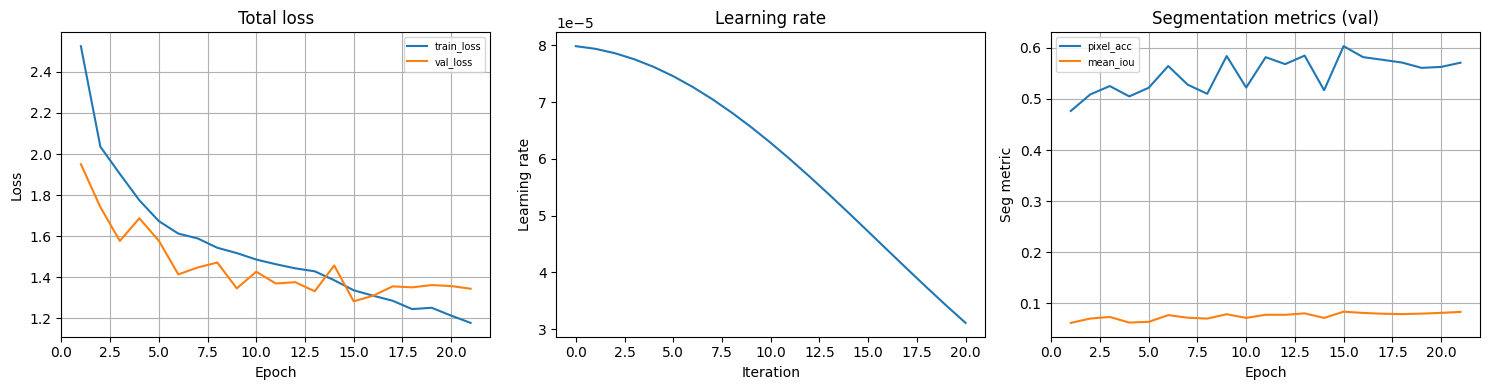

In [83]:
plot_curves(history, task="seg")

Test features for confusion: 100%|██████████| 20/20 [00:00<00:00, 85.31it/s] 


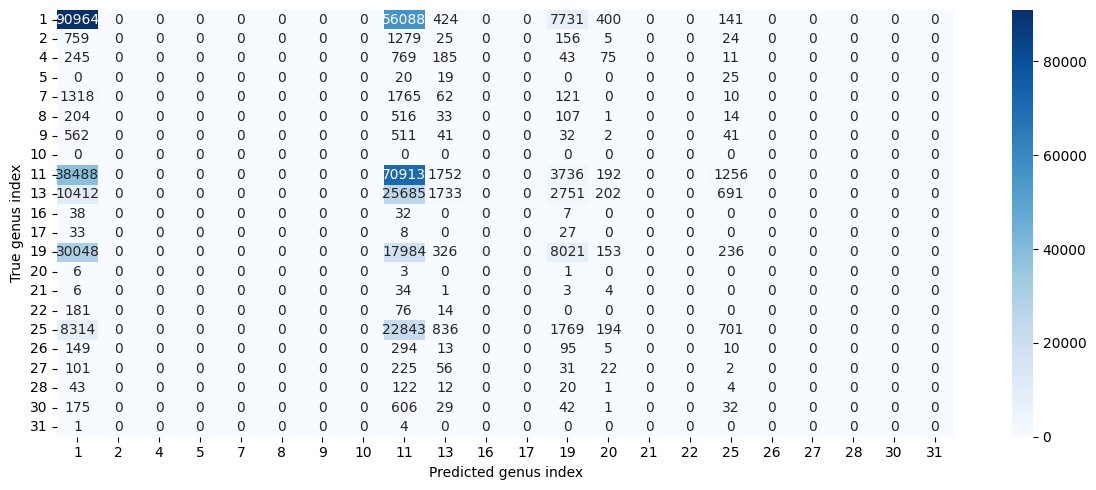

In [77]:
plot_cm(model, test_loader, device, num_classes)

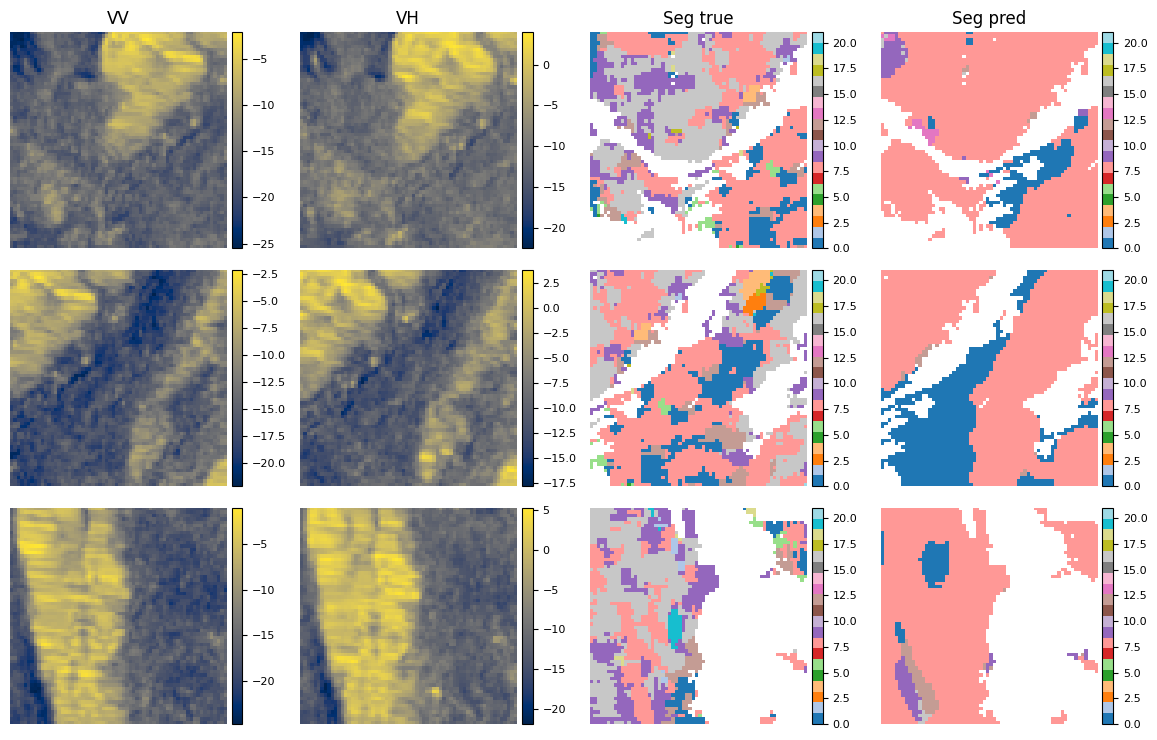

In [84]:
visualize_segmentation_samples(model, test_ds, 50, 3, device)

### Height Regression

In [85]:
configs.update(
    base_channels=128,
    max_lr=1e-4,
    weight_decay=1e-4,
    patience=8,
    dropout=0.3,
    epochs=100,
)
model = RegressionUNet(
    in_channels=2,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)

reg_criterion = masked_rmse_loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * configs["epochs"]
scheduler = None
num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_height_rmse": [],
    "val_height_r2": [],
    "lr": []
}

In [86]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_regression(
        model,
        train_loader,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        target="height"
    )

    val_metrics = evaluate_regression(
        model,
        val_loader,
        reg_criterion,
        device,
        desc=f"Val Reg {epoch}",
        target="height"
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_height_rmse"].append(val_metrics["height_rmse"])
    history["val_height_r2"].append(val_metrics["height_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"height RMSE={val_metrics['height_rmse']:.4f}, "
        f"height R2={val_metrics['height_r2']:.4f}, "
    )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

Val Reg 1: 100%|██████████| 20/20 [00:00<00:00, 76.25it/s]


Epoch 1: train loss=22.6099, val loss=22.2462, height RMSE=22.3657, height R2=-14.8916, 
	Updated best model


Val Reg 2: 100%|██████████| 20/20 [00:00<00:00, 87.66it/s]


Epoch 2: train loss=21.6341, val loss=18.7404, height RMSE=18.8670, height R2=-10.3086, 
	Updated best model


Val Reg 3: 100%|██████████| 20/20 [00:00<00:00, 89.79it/s]


Epoch 3: train loss=21.0440, val loss=18.0315, height RMSE=18.2270, height R2=-9.5543, 
	Updated best model


Val Reg 4: 100%|██████████| 20/20 [00:00<00:00, 88.94it/s]


Epoch 4: train loss=20.4210, val loss=19.7098, height RMSE=19.6743, height R2=-11.2970, 
	Patience 1/8


Val Reg 5: 100%|██████████| 20/20 [00:00<00:00, 90.19it/s]


Epoch 5: train loss=19.8523, val loss=21.2016, height RMSE=21.4629, height R2=-13.6346, 
	Patience 2/8


Val Reg 6: 100%|██████████| 20/20 [00:00<00:00, 89.60it/s]


Epoch 6: train loss=19.3165, val loss=17.1553, height RMSE=17.3466, height R2=-8.5595, 
	Updated best model


Val Reg 7: 100%|██████████| 20/20 [00:00<00:00, 90.01it/s]


Epoch 7: train loss=18.4949, val loss=17.8649, height RMSE=17.6853, height R2=-8.9363, 
	Patience 1/8


Val Reg 8: 100%|██████████| 20/20 [00:00<00:00, 90.12it/s]


Epoch 8: train loss=17.8142, val loss=13.7724, height RMSE=13.9451, height R2=-5.1780, 
	Updated best model


Val Reg 9: 100%|██████████| 20/20 [00:00<00:00, 87.58it/s]


Epoch 9: train loss=17.0461, val loss=15.2944, height RMSE=14.9551, height R2=-6.1052, 
	Patience 1/8


Val Reg 10: 100%|██████████| 20/20 [00:00<00:00, 89.98it/s]


Epoch 10: train loss=16.4394, val loss=18.2270, height RMSE=18.2910, height R2=-9.6286, 
	Patience 2/8


Val Reg 11: 100%|██████████| 20/20 [00:00<00:00, 89.44it/s]


Epoch 11: train loss=15.7253, val loss=12.4480, height RMSE=12.4105, height R2=-3.8931, 
	Updated best model


Val Reg 12: 100%|██████████| 20/20 [00:00<00:00, 89.58it/s]


Epoch 12: train loss=14.9876, val loss=13.6979, height RMSE=13.5864, height R2=-4.8642, 
	Patience 1/8


Val Reg 13: 100%|██████████| 20/20 [00:00<00:00, 88.57it/s]


Epoch 13: train loss=14.0458, val loss=13.1413, height RMSE=12.8513, height R2=-4.2468, 
	Patience 2/8


Val Reg 14: 100%|██████████| 20/20 [00:00<00:00, 88.95it/s]


Epoch 14: train loss=13.3925, val loss=10.9204, height RMSE=10.7590, height R2=-2.6774, 
	Updated best model


Val Reg 15: 100%|██████████| 20/20 [00:00<00:00, 91.59it/s]


Epoch 15: train loss=12.5385, val loss=10.6785, height RMSE=10.4086, height R2=-2.4418, 
	Updated best model


Val Reg 16: 100%|██████████| 20/20 [00:00<00:00, 91.30it/s]


Epoch 16: train loss=11.8820, val loss=9.8853, height RMSE=9.7965, height R2=-2.0489, 
	Updated best model


Val Reg 17: 100%|██████████| 20/20 [00:00<00:00, 88.65it/s]


Epoch 17: train loss=11.2004, val loss=8.8794, height RMSE=8.6738, height R2=-1.3901, 
	Updated best model


Val Reg 18: 100%|██████████| 20/20 [00:00<00:00, 88.10it/s]


Epoch 18: train loss=10.2900, val loss=8.7510, height RMSE=8.4869, height R2=-1.2882, 
	Updated best model


Val Reg 19: 100%|██████████| 20/20 [00:00<00:00, 88.89it/s]


Epoch 19: train loss=9.7350, val loss=11.1990, height RMSE=10.9753, height R2=-2.8268, 
	Patience 1/8


Val Reg 20: 100%|██████████| 20/20 [00:00<00:00, 88.41it/s]


Epoch 20: train loss=8.9536, val loss=10.5266, height RMSE=10.2392, height R2=-2.3307, 
	Patience 2/8


Val Reg 21: 100%|██████████| 20/20 [00:00<00:00, 91.27it/s]


Epoch 21: train loss=8.1882, val loss=7.2197, height RMSE=7.0585, height R2=-0.5828, 
	Updated best model


Val Reg 22: 100%|██████████| 20/20 [00:00<00:00, 89.99it/s]


Epoch 22: train loss=7.7945, val loss=10.6504, height RMSE=10.2286, height R2=-2.3238, 
	Patience 1/8


Val Reg 23: 100%|██████████| 20/20 [00:00<00:00, 90.39it/s]


Epoch 23: train loss=7.3570, val loss=7.0429, height RMSE=6.9078, height R2=-0.5159, 
	Updated best model


Val Reg 24: 100%|██████████| 20/20 [00:00<00:00, 89.73it/s]


Epoch 24: train loss=7.0390, val loss=6.6676, height RMSE=6.5202, height R2=-0.3506, 
	Updated best model


Val Reg 25: 100%|██████████| 20/20 [00:00<00:00, 88.44it/s]


Epoch 25: train loss=6.6456, val loss=6.9067, height RMSE=6.8107, height R2=-0.4736, 
	Patience 1/8


Val Reg 26: 100%|██████████| 20/20 [00:00<00:00, 89.99it/s]


Epoch 26: train loss=6.3597, val loss=5.9312, height RMSE=5.9221, height R2=-0.1142, 
	Updated best model


Val Reg 27: 100%|██████████| 20/20 [00:00<00:00, 92.12it/s]


Epoch 27: train loss=6.1395, val loss=6.8777, height RMSE=6.7444, height R2=-0.4451, 
	Patience 1/8


Val Reg 28: 100%|██████████| 20/20 [00:00<00:00, 92.08it/s]


Epoch 28: train loss=5.8659, val loss=5.8289, height RMSE=5.7967, height R2=-0.0675, 
	Updated best model


Val Reg 29: 100%|██████████| 20/20 [00:00<00:00, 89.26it/s]


Epoch 29: train loss=5.7538, val loss=6.0538, height RMSE=6.0220, height R2=-0.1521, 
	Patience 1/8


Val Reg 30: 100%|██████████| 20/20 [00:00<00:00, 91.11it/s]


Epoch 30: train loss=5.5924, val loss=6.1185, height RMSE=6.1440, height R2=-0.1992, 
	Patience 2/8


Val Reg 31: 100%|██████████| 20/20 [00:00<00:00, 89.18it/s]


Epoch 31: train loss=5.5107, val loss=6.0772, height RMSE=6.0108, height R2=-0.1478, 
	Patience 3/8


Val Reg 32: 100%|██████████| 20/20 [00:00<00:00, 88.21it/s]


Epoch 32: train loss=5.3423, val loss=5.6389, height RMSE=5.6464, height R2=-0.0129, 
	Updated best model


Val Reg 33: 100%|██████████| 20/20 [00:00<00:00, 91.22it/s]


Epoch 33: train loss=5.3110, val loss=5.9278, height RMSE=5.8333, height R2=-0.0810, 
	Patience 1/8


Val Reg 34: 100%|██████████| 20/20 [00:00<00:00, 90.27it/s]


Epoch 34: train loss=5.1921, val loss=5.8210, height RMSE=5.8192, height R2=-0.0758, 
	Patience 2/8


Val Reg 35: 100%|██████████| 20/20 [00:00<00:00, 91.14it/s]


Epoch 35: train loss=5.0460, val loss=5.4401, height RMSE=5.4267, height R2=0.0644, 
	Updated best model


Val Reg 36: 100%|██████████| 20/20 [00:00<00:00, 88.68it/s]


Epoch 36: train loss=5.0215, val loss=5.5472, height RMSE=5.5630, height R2=0.0169, 
	Patience 1/8


Val Reg 37: 100%|██████████| 20/20 [00:00<00:00, 92.72it/s]


Epoch 37: train loss=4.9824, val loss=5.6948, height RMSE=5.7926, height R2=-0.0660, 
	Patience 2/8


Val Reg 38: 100%|██████████| 20/20 [00:00<00:00, 86.24it/s]


Epoch 38: train loss=4.8177, val loss=5.8424, height RMSE=5.8290, height R2=-0.0794, 
	Patience 3/8


Val Reg 39: 100%|██████████| 20/20 [00:00<00:00, 91.03it/s]


Epoch 39: train loss=4.7403, val loss=5.8914, height RMSE=5.8074, height R2=-0.0714, 
	Patience 4/8


Val Reg 40: 100%|██████████| 20/20 [00:00<00:00, 89.15it/s]


Epoch 40: train loss=4.7163, val loss=5.6318, height RMSE=5.6327, height R2=-0.0080, 
	Patience 5/8


Val Reg 41: 100%|██████████| 20/20 [00:00<00:00, 94.12it/s]


Epoch 41: train loss=4.6275, val loss=5.5366, height RMSE=5.5715, height R2=0.0138, 
	Patience 6/8


Val Reg 42: 100%|██████████| 20/20 [00:00<00:00, 89.42it/s]


Epoch 42: train loss=4.6122, val loss=5.4582, height RMSE=5.4516, height R2=0.0558, 
	Patience 7/8


Val Reg 43: 100%|██████████| 20/20 [00:00<00:00, 90.47it/s]


Epoch 43: train loss=4.5943, val loss=5.3835, height RMSE=5.3877, height R2=0.0778, 
	Updated best model


Val Reg 44: 100%|██████████| 20/20 [00:00<00:00, 88.32it/s]


Epoch 44: train loss=4.5468, val loss=5.3646, height RMSE=5.4012, height R2=0.0732, 
	Updated best model


Val Reg 45: 100%|██████████| 20/20 [00:00<00:00, 90.72it/s]


Epoch 45: train loss=4.4599, val loss=5.4422, height RMSE=5.4816, height R2=0.0454, 
	Patience 1/8


Val Reg 46: 100%|██████████| 20/20 [00:00<00:00, 90.20it/s]


Epoch 46: train loss=4.3662, val loss=5.4177, height RMSE=5.4437, height R2=0.0585, 
	Patience 2/8


Val Reg 47: 100%|██████████| 20/20 [00:00<00:00, 92.18it/s]


Epoch 47: train loss=4.3759, val loss=5.4992, height RMSE=5.4953, height R2=0.0406, 
	Patience 3/8


Val Reg 48: 100%|██████████| 20/20 [00:00<00:00, 91.20it/s]


Epoch 48: train loss=4.4069, val loss=5.7219, height RMSE=5.7056, height R2=-0.0342, 
	Patience 4/8


Val Reg 49: 100%|██████████| 20/20 [00:00<00:00, 90.77it/s]


Epoch 49: train loss=4.3520, val loss=5.5466, height RMSE=5.5953, height R2=0.0054, 
	Patience 5/8


Val Reg 50: 100%|██████████| 20/20 [00:00<00:00, 88.17it/s]


Epoch 50: train loss=4.3207, val loss=5.4901, height RMSE=5.4968, height R2=0.0401, 
	Patience 6/8


Val Reg 51: 100%|██████████| 20/20 [00:00<00:00, 90.07it/s]


Epoch 51: train loss=4.2083, val loss=5.5416, height RMSE=5.5773, height R2=0.0118, 
	Patience 7/8


Val Reg 52: 100%|██████████| 20/20 [00:00<00:00, 86.22it/s]

Epoch 52: train loss=4.2297, val loss=5.5485, height RMSE=5.6042, height R2=0.0022, 
	Patience 8/8
Early stopping triggered


In [87]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics = evaluate_regression(
    model,
    test_loader,
    reg_criterion,
    device,
    desc="Test Reg",
    target="height"
)

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test Reg: 100%|██████████| 20/20 [00:00<00:00, 80.24it/s] 


Test metrics:
  loss: 6.5265
  height_loss: 6.5265
  height_rmse: 6.7279
  height_r2: 0.0061


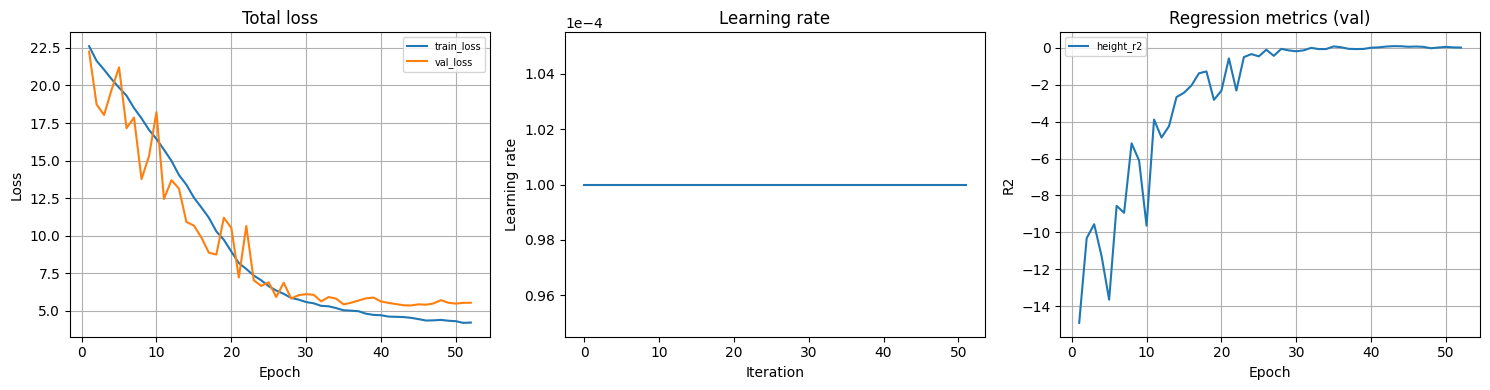

In [88]:
plot_curves(history, task="reg")

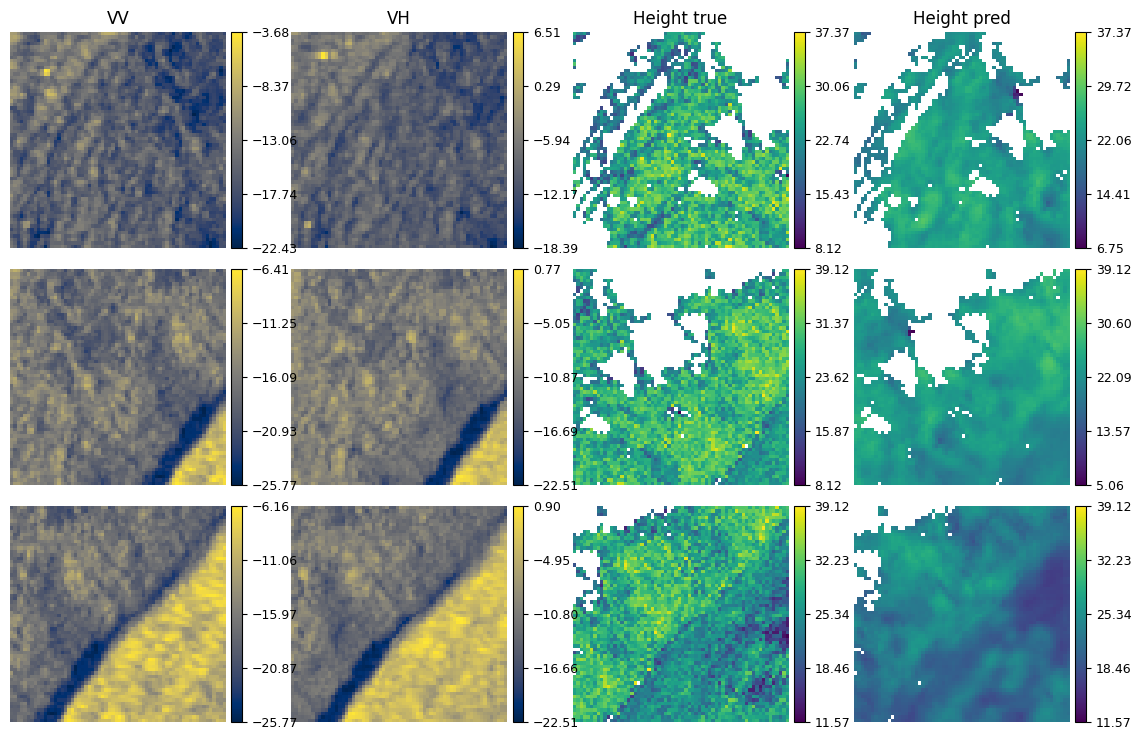

In [89]:
visualize_regression_samples(model, test_ds, 0, 3, device, target="height")

Collect reg pairs: 100%|██████████| 10/10 [00:00<00:00, 41.98it/s]


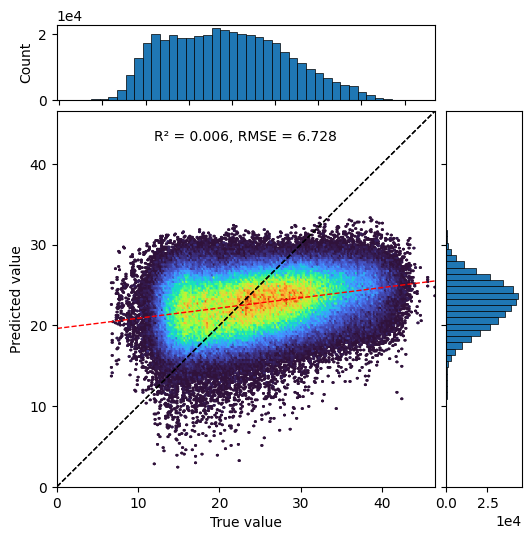

In [90]:
test_true, test_pred = collect_regression_pairs(model, target="height")
plot_regression_joint_with_hists(test_true, test_pred)

### Biomass Regression

In [98]:
configs.update(
    base_channels=128,
    max_lr=5e-4,
    weight_decay=1e-5,
    patience=6,
    dropout=0.2,
    epochs=100,
)
model = RegressionUNet(
    in_channels=2,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)

reg_criterion = masked_rmse_loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * configs["epochs"]
scheduler = None
num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_biomass_r2": [],
    "lr": []
}

In [99]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_regression(
        model,
        train_loader,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        target="biomass"
    )

    val_metrics = evaluate_regression(
        model,
        val_loader,
        reg_criterion,
        device,
        desc=f"Val Reg {epoch}",
        target="biomass"
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_biomass_r2"].append(val_metrics["biomass_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"biomass R2={val_metrics['biomass_r2']:.4f}, "
    )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

Val Reg 1: 100%|██████████| 20/20 [00:00<00:00, 89.63it/s]


Epoch 1: train loss=77.5677, val loss=76.8162, biomass R2=-2.8983, 
	Updated best model


Val Reg 2: 100%|██████████| 20/20 [00:00<00:00, 92.41it/s]


Epoch 2: train loss=75.0282, val loss=70.7365, biomass R2=-2.3373, 
	Updated best model


Val Reg 3: 100%|██████████| 20/20 [00:00<00:00, 89.80it/s]


Epoch 3: train loss=71.1313, val loss=65.3972, biomass R2=-1.8916, 
	Updated best model


Val Reg 4: 100%|██████████| 20/20 [00:00<00:00, 87.27it/s]


Epoch 4: train loss=66.8131, val loss=72.9265, biomass R2=-2.5029, 
	Patience 1/6


Val Reg 5: 100%|██████████| 20/20 [00:00<00:00, 89.58it/s]


Epoch 5: train loss=61.0364, val loss=72.1976, biomass R2=-2.4736, 
	Patience 2/6


Val Reg 6: 100%|██████████| 20/20 [00:00<00:00, 83.74it/s] 


Epoch 6: train loss=55.1911, val loss=59.9218, biomass R2=-1.3229, 
	Updated best model


Val Reg 7: 100%|██████████| 20/20 [00:00<00:00, 88.74it/s]


Epoch 7: train loss=48.7090, val loss=41.2378, biomass R2=-0.1276, 
	Updated best model


Val Reg 8: 100%|██████████| 20/20 [00:00<00:00, 89.44it/s]


Epoch 8: train loss=44.5196, val loss=39.9214, biomass R2=-0.0332, 
	Updated best model


Val Reg 9: 100%|██████████| 20/20 [00:00<00:00, 84.04it/s]


Epoch 9: train loss=41.8322, val loss=44.0093, biomass R2=-0.2750, 
	Patience 1/6


Val Reg 10: 100%|██████████| 20/20 [00:00<00:00, 89.54it/s]


Epoch 10: train loss=40.5419, val loss=40.0252, biomass R2=-0.0247, 
	Patience 2/6


Val Reg 11: 100%|██████████| 20/20 [00:00<00:00, 89.94it/s]


Epoch 11: train loss=39.9937, val loss=41.5903, biomass R2=-0.1218, 
	Patience 3/6


Val Reg 12: 100%|██████████| 20/20 [00:00<00:00, 88.87it/s]


Epoch 12: train loss=39.5576, val loss=40.2307, biomass R2=-0.0654, 
	Patience 4/6


Val Reg 13: 100%|██████████| 20/20 [00:00<00:00, 81.81it/s] 


Epoch 13: train loss=38.9801, val loss=38.4644, biomass R2=0.0707, 
	Updated best model


Val Reg 14: 100%|██████████| 20/20 [00:00<00:00, 89.90it/s]


Epoch 14: train loss=38.9265, val loss=39.6819, biomass R2=0.0079, 
	Patience 1/6


Val Reg 15: 100%|██████████| 20/20 [00:00<00:00, 85.22it/s]


Epoch 15: train loss=38.5763, val loss=38.6238, biomass R2=0.0740, 
	Patience 2/6


Val Reg 16: 100%|██████████| 20/20 [00:00<00:00, 91.90it/s]


Epoch 16: train loss=38.6358, val loss=38.3509, biomass R2=0.0771, 
	Updated best model


Val Reg 17: 100%|██████████| 20/20 [00:00<00:00, 92.09it/s]


Epoch 17: train loss=38.7238, val loss=38.8631, biomass R2=0.0304, 
	Patience 1/6


Val Reg 18: 100%|██████████| 20/20 [00:00<00:00, 87.41it/s]


Epoch 18: train loss=38.4454, val loss=38.8435, biomass R2=0.0004, 
	Patience 2/6


Val Reg 19: 100%|██████████| 20/20 [00:00<00:00, 86.89it/s]


Epoch 19: train loss=38.2098, val loss=37.9532, biomass R2=0.0650, 
	Updated best model


Val Reg 20: 100%|██████████| 20/20 [00:00<00:00, 89.70it/s]


Epoch 20: train loss=38.1058, val loss=38.1340, biomass R2=0.0801, 
	Patience 1/6


Val Reg 21: 100%|██████████| 20/20 [00:00<00:00, 83.04it/s]


Epoch 21: train loss=38.2858, val loss=37.9748, biomass R2=0.0923, 
	Patience 2/6


Val Reg 22: 100%|██████████| 20/20 [00:00<00:00, 87.29it/s]


Epoch 22: train loss=37.8104, val loss=41.7523, biomass R2=-0.1533, 
	Patience 3/6


Val Reg 23: 100%|██████████| 20/20 [00:00<00:00, 91.34it/s]


Epoch 23: train loss=37.6538, val loss=38.9312, biomass R2=0.0554, 
	Patience 4/6


Val Reg 24: 100%|██████████| 20/20 [00:00<00:00, 88.72it/s]


Epoch 24: train loss=37.9749, val loss=37.8043, biomass R2=0.0938, 
	Updated best model


Val Reg 25: 100%|██████████| 20/20 [00:00<00:00, 88.19it/s]


Epoch 25: train loss=37.3302, val loss=39.8714, biomass R2=-0.0222, 
	Patience 1/6


Val Reg 26: 100%|██████████| 20/20 [00:00<00:00, 88.11it/s]


Epoch 26: train loss=36.9128, val loss=39.0608, biomass R2=0.0125, 
	Patience 2/6


Val Reg 27: 100%|██████████| 20/20 [00:00<00:00, 91.37it/s]


Epoch 27: train loss=37.1548, val loss=51.4999, biomass R2=-0.7472, 
	Patience 3/6


Val Reg 28: 100%|██████████| 20/20 [00:00<00:00, 91.36it/s]


Epoch 28: train loss=36.7008, val loss=39.2822, biomass R2=0.0176, 
	Patience 4/6


Val Reg 29: 100%|██████████| 20/20 [00:00<00:00, 89.80it/s]


Epoch 29: train loss=36.0545, val loss=39.5214, biomass R2=0.0084, 
	Patience 5/6


Val Reg 30: 100%|██████████| 20/20 [00:00<00:00, 89.63it/s]

Epoch 30: train loss=35.7976, val loss=39.2459, biomass R2=0.0205, 
	Patience 6/6
Early stopping triggered


In [100]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics = evaluate_regression(
    model,
    test_loader,
    reg_criterion,
    device,
    desc="Test Reg",
    target="biomass"
)

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test Reg: 100%|██████████| 20/20 [00:00<00:00, 78.78it/s]


Test metrics:
  loss: 37.1160
  biomass_loss: 37.1160
  biomass_rmse: 37.0999
  biomass_r2: 0.0284


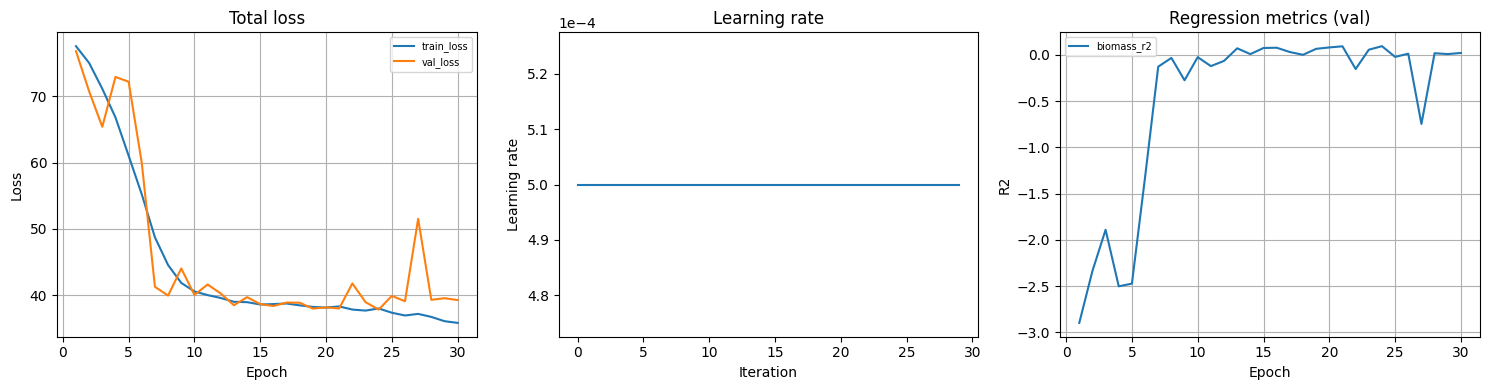

In [101]:
plot_curves(history, task="reg", target="biomass")

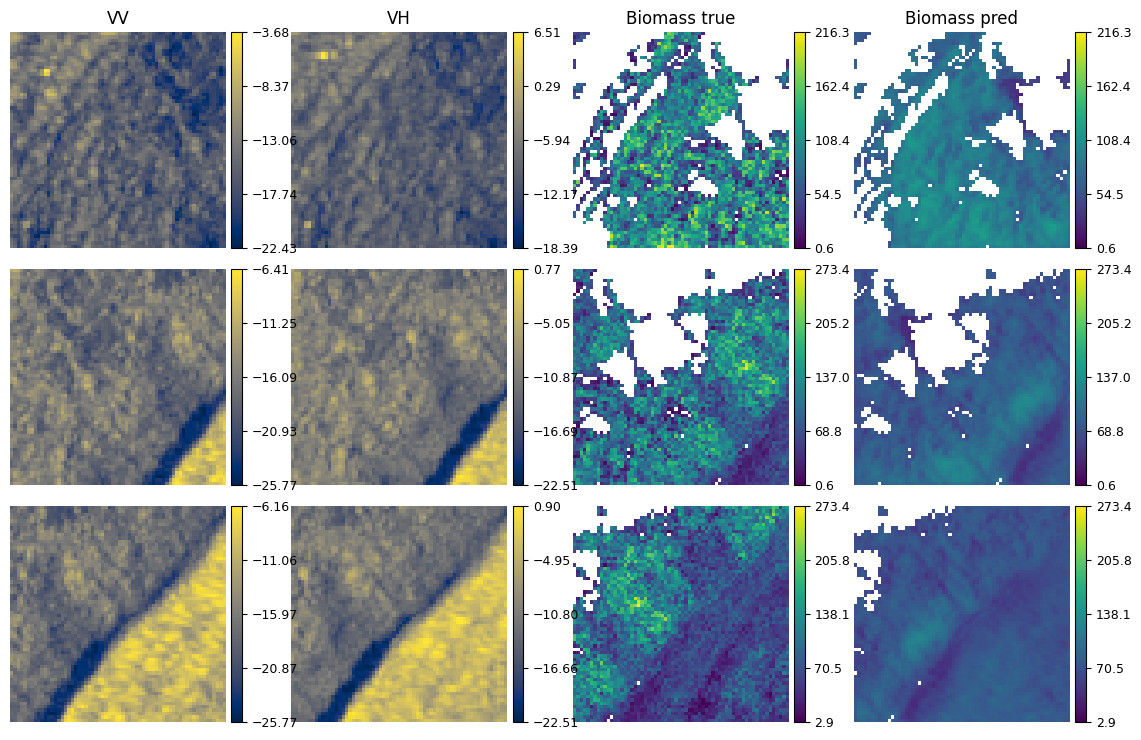

In [102]:
visualize_regression_samples(model, test_ds, 0, 3, device, target="biomass")

Collect reg pairs: 100%|██████████| 10/10 [00:00<00:00, 50.33it/s]


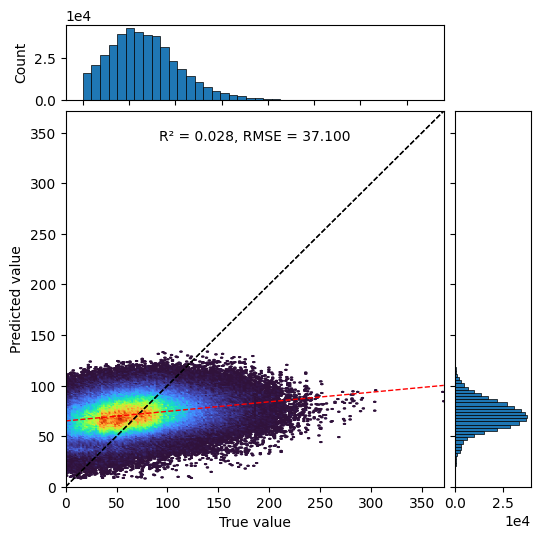

In [103]:
test_true, test_pred = collect_regression_pairs(model, target="biomass")
plot_regression_joint_with_hists(test_true, test_pred)